# Zero-Shot Image Search
We're going to use the CLIP model which is pretrained on the ImageNet dataset. The dataset that we're searching images on is the ImageNetTE dataset by Jeremy Howard.

ImageNetTE is a subset of the ImageNet dataset, containing 10 easy to classify classes. We're going to give in a prompt containing one of the classes and we'll see if CLIP can give us relevant images from the dataset.

In [93]:
!pip install torch transformers datasets -q

In [94]:
from datasets import load_dataset

imagenette = load_dataset("frgfm/imagenette", "full_size", split='train')
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

In [95]:
# Checking out all the classes available in the dataset.
print(imagenette.features['label'].names)

['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


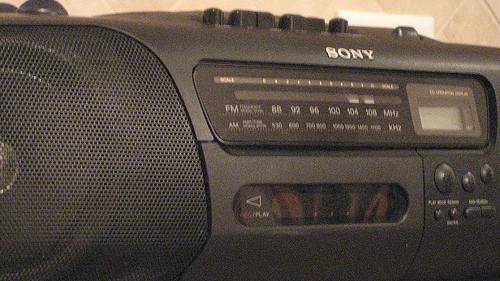

In [96]:
# Looking at the first image.
imagenette[0]['image']

In [97]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

model_id = 'openai/clip-vit-base-patch32'

model = CLIPModel.from_pretrained(model_id).to(device)  # The actual model
tokenizer = CLIPTokenizerFast.from_pretrained(model_id) # Text to embeddings
processor = CLIPProcessor.from_pretrained(model_id)     # Image to embeddings

In [98]:
prompt = "a music playing device"

# tokenize the prompt
inputs = tokenizer(prompt, return_tensors='pt')
inputs

{'input_ids': tensor([[49406,   320,  1179,  1629,  8163, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

input_ids -> Contains token ids that represent the word in the sentence.

The attention mask has all 1s. If we had padding, anything beyond the length of our prompt would be 0, telling the model to not pay attention to it.

In [99]:
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

We're using the processor to preprocess the images for inference, applying transformations so that the images are similar to what the model was trained on.

In [100]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)

image

{'pixel_values': tensor([[[[ 1.7552,  1.7698,  1.8135,  ...,  1.6968,  1.7114,  1.6530],
          [ 1.7406,  1.7698,  1.7406,  ...,  1.6384,  1.6238,  1.6968],
          [ 1.6530,  1.6968,  1.6968,  ...,  1.6384,  1.6530,  1.6530],
          ...,
          [-1.4273, -1.3105, -1.2667,  ..., -1.1353, -1.0915, -1.1207],
          [-1.1353, -1.3251, -1.3251,  ..., -1.2667, -1.2083, -1.1207],
          [-0.9018, -1.2667, -1.3251,  ..., -1.1499, -1.1061, -1.1937]],

         [[ 1.4446,  1.3995,  1.5046,  ...,  1.2945,  1.3245,  1.3095],
          [ 1.4295,  1.4145,  1.4295,  ...,  1.2945,  1.2344,  1.2945],
          [ 1.3545,  1.3845,  1.3845,  ...,  1.2795,  1.3095,  1.2795],
          ...,
          [-1.3469, -1.1968, -1.2418,  ..., -1.1368, -1.1218, -1.1818],
          [-1.0918, -1.2268, -1.2268,  ..., -1.1668, -1.1668, -1.1668],
          [-0.8816, -1.1818, -1.1818,  ..., -1.1068, -1.1368, -1.2268]],

         [[ 1.0794,  1.1078,  1.1078,  ...,  1.0083,  1.0083,  0.8803],
          [ 1

In [101]:
image = image['pixel_values'] # Getting the image because processor outputs a dict.
image.shape

torch.Size([1, 3, 224, 224])

In [102]:
image.squeeze(0).permute(1, 2, 0).shape # We need to reshape the image to display using matplotlib

torch.Size([224, 224, 3])

Visualizing our images after applying the processing. We can see in the image below that it doesn't look like our original image.

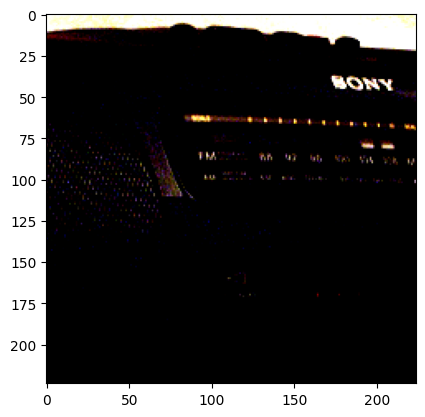

In [103]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0).permute(1, 2, 0))

In [104]:
# Converting the image to image embedding format which the CLIP model expects.
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [105]:
import numpy as np

# Setting random seed
np.random.seed(42)

# Picking 100 random indices.
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
images = [imagenette[i]['image'] for i in sample_idx]
len(images)

100

In [106]:
from tqdm.auto import tqdm

batch_size = 32
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
  # Select batch of images
  batch = images[i:i+batch_size]
  # Process the batch and resize as required.
  batch = processor(
      text=None,
      images=batch,
      return_tensors='pt',
      padding=True
  )['pixel_values'].to(device)  # (32, 3, 224, 224)
  # Get image embeddings
  batch_emb = model.get_image_features(pixel_values=batch)  # (32, 512)
  # Convert to numpy array
  batch_emb = batch_emb.cpu().detach().numpy()
  # Add to larger array of all image embeddings
  if image_arr is None:
    image_arr = batch_emb
  else:
    image_arr = np.concatenate((image_arr, batch_emb), axis=0)

image_arr.shape

  0%|          | 0/4 [00:00<?, ?it/s]

(100, 512)

In [107]:
image_arr.min(), image_arr.max()

(-9.091132, 3.650619)

Dot Product Similarity

Definition: The dot product measures the degree of similarity based on both the direction and the magnitude of the vectors. If the vectors are in the same direction and have large magnitudes, the dot product will be large. If they are in opposite directions, the dot product will be negative. If one or both vectors have small magnitudes, the dot product will be small even if they point in the same direction.

Scale Dependency: The dot product is scale-dependent. If you scale up the magnitude of one or both vectors (e.g., by multiplying them by a constant), the dot product increases, even if the vectors' directions remain the same.

We normalize the image embeddings so that we can only focus on the angle, the magnitude should not affect the similarity as much.

If we were using cosine similarity, we wouldn't have to do this step here.

`np.linalg.norm(image_arr, axis=1)` computes the vector norms along the rows of the `image_arr` using axis=1, which computes the Euclidean (L2) norm for each row vector.

In [108]:
# This contains the L2 norm calculated across axis 1.
# Since our embeddings are in the shape (100, 512), we calculate L2 norm of each embedding.
# Thus, we get 100 L2 norm values here.
np.linalg.norm(image_arr, axis=1), np.linalg.norm(image_arr, axis=1).shape # 100 values

(array([ 9.529712 , 10.508783 , 10.683979 ,  9.657528 , 10.54378  ,
        10.011743 , 11.470616 , 10.142126 , 11.2417   , 10.300414 ,
         9.616388 , 10.753282 , 10.079945 , 10.226761 , 10.503269 ,
        10.242999 ,  9.705638 ,  9.584947 ,  9.724625 ,  8.978424 ,
        10.452247 , 10.888629 ,  9.463258 ,  9.970942 , 10.224886 ,
        10.358861 , 10.867866 , 11.160349 ,  9.618787 , 10.565282 ,
         8.950003 , 10.583962 ,  9.890223 , 10.657271 , 10.818477 ,
         9.4974375, 10.457945 , 10.451728 , 10.914341 , 10.107171 ,
        10.473815 , 10.817262 ,  9.7218   , 11.373079 , 11.209726 ,
        10.352363 , 10.339112 ,  9.949797 ,  9.93369  , 10.518985 ,
        10.796502 ,  9.97312  , 11.105114 , 10.580154 , 10.07049  ,
         9.859064 , 10.146964 ,  9.309978 , 10.220114 , 10.844065 ,
        10.539926 , 10.505332 , 10.488182 , 10.158248 , 11.076651 ,
        10.675406 , 10.441278 ,  8.626152 , 10.358963 , 11.817946 ,
         9.780078 , 10.687835 , 10.253756 , 10.2

In [109]:
# Taking transpose so embedding becomes column, each row has 100 embeddings, each for a single image
# Now, we divide 100 embeddings with their respective L2 norm values to normalize.
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)
image_arr.shape

(512, 100)

In [110]:
image_arr = image_arr.T # Taking transpose again to get it in correct shape for CLIP.
image_arr.shape, image_arr.min(), image_arr.max()

((100, 512), -0.78284144, 0.3729747)

In [111]:
# Converting text embedding to numpy array.
text_emb = text_emb.cpu().detach().numpy()  # (1, 512)

Since we gave a single prompt as input, this operation finds out the dot product similarity score between that text embedding (let's say T_1) and the 100 image embeddings (I_1 to I_100).

In [112]:
# Finding dot product similarity
scores = np.dot(text_emb, image_arr.T)
scores, scores.shape

(array([[1.9351403, 2.6278832, 2.5257483, 2.0800214, 1.8787711, 1.531122 ,
         2.5543   , 2.1209192, 2.1258144, 1.834372 , 1.7103013, 2.4839797,
         1.8018076, 1.9093024, 2.3472161, 2.1291287, 1.7529279, 1.7421632,
         1.926223 , 1.8477447, 1.8953966, 2.8965302, 3.0859241, 2.5143557,
         2.0715084, 2.4914265, 2.3583565, 2.6672924, 2.1438725, 2.3516538,
         1.9408426, 2.0216143, 1.7750777, 2.2089312, 1.891822 , 1.9547108,
         2.270211 , 2.0260026, 3.1725023, 2.2108462, 2.847218 , 1.8429393,
         1.8923098, 2.9760203, 2.5336478, 2.1673062, 2.3647206, 1.800459 ,
         2.560319 , 2.0461795, 1.8477573, 1.8641982, 2.2115195, 1.8374937,
         1.880985 , 2.0069876, 2.1413963, 1.861558 , 2.2108545, 1.7624803,
         1.9025362, 1.8484577, 1.9934417, 1.9675717, 2.5594115, 2.0894773,
         1.9434962, 1.8499047, 1.9196295, 2.1030884, 2.2806704, 2.864995 ,
         2.6501503, 3.0112047, 2.4359937, 2.4743333, 1.7937609, 2.573379 ,
         2.6184797, 2.212

In [113]:
# Getting the index locations having the highest 5 similarity scores.
idx = np.argsort(-scores[0])[:5]  # -scores[0] because we want sorting in descending order
idx

array([38, 22, 73, 43, 82])

3.1725023


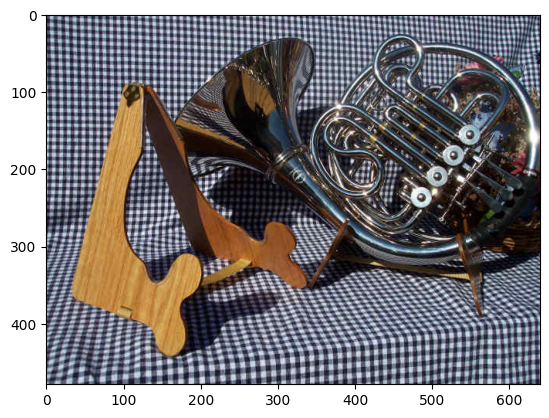

3.0859241


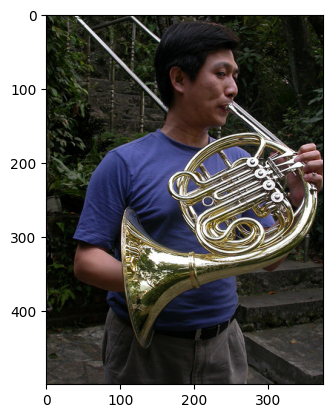

3.0112047


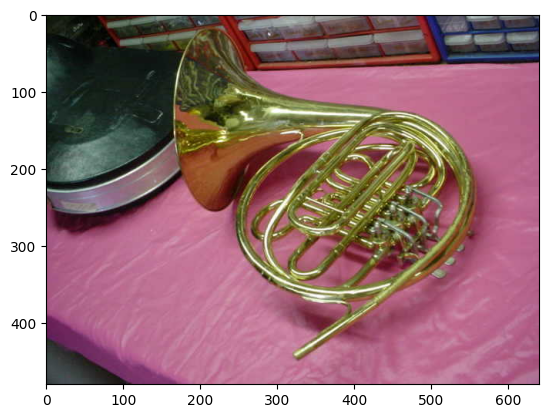

2.9760203


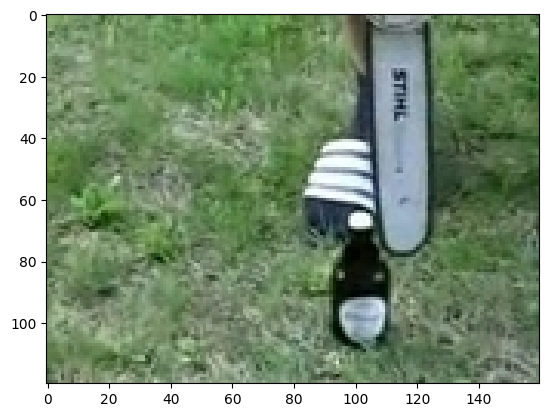

2.975768


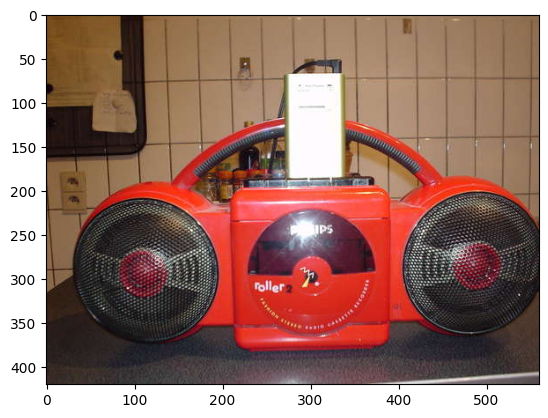

In [114]:
# Displaying the images which have the highest similarity to the prompt.
for i in idx:
  print(scores[0][i])
  plt.imshow(images[i])
  plt.show()